Import Required Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import csv
from sklearn.datasets import fetch_20newsgroups

Load the 20 news group dataset

In [2]:
%%time
dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

CPU times: user 10.4 s, sys: 3.55 s, total: 13.9 s
Wall time: 24.8 s


In [3]:
df = pd.DataFrame(list(dataset.data), columns=['text'])
df["label"] = list(dataset.target)

In [4]:
df.head()

,text,label
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18846 non-null  object
 1   label   18846 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 294.6+ KB


Clean the textual data

In [6]:
def clean_and_tokenize_text(news_data):
  cleaned_text = []
  # iterate over the news data
  for text in news_data:
    # only keep numbers and letters and spaces
    text = re.sub('[^\w]|_', ' ', text)
    # convert to lower case
    text = text.lower()
    # remove non ascii texts
    text = re.sub(r'[^\x00-\x7f]',r'', text)  
    # remove empty words
    tokens = [token for token in text.split(' ') if token]
    # convert all numbers to '[number]' to reduce vocab size
    tokens = ['[number]' if token.isdigit() else token for token in tokens] 
    cleaned_text.append(tokens)
  return cleaned_text

In [7]:
clean_train_tokens = clean_and_tokenize_text(dataset.data)

In [8]:
def get_unique_tokens_per_row(text_token_list):
    words = []
    for row in text_token_list:
        words.extend(list(set(row)))
    return words

Plot to check how many documents contain each token:

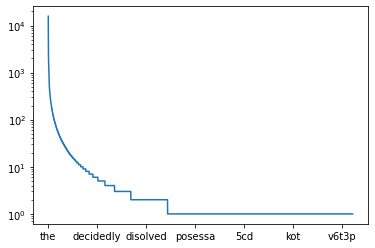

In [11]:
words = pd.DataFrame(get_unique_tokens_per_row(clean_train_tokens) , columns=['words'])
token_frequency = words['words'].value_counts() 
token_frequency.plot(logy=True)

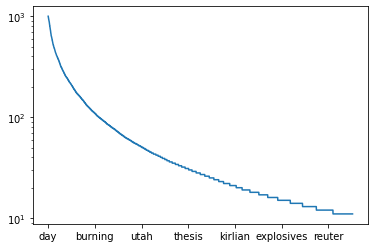

In [12]:
vocab = token_frequency[np.logical_and(token_frequency < 1000, token_frequency > 10)]
vocab.plot(logy=True)

In [13]:
# Remove tokens which are not in vocabulary
def filter_text_by_vocab(news_data, vocab):
    text_strs = []
    for row in news_data:
        words_to_keep = [token for token in row if token in vocab or token == '[number]']
        text_strs.append(' '.join(words_to_keep))
    return text_strs

In [14]:
clean_data = filter_text_by_vocab(clean_train_tokens, set(vocab.index))

In [15]:
clean_data[:2]

['pens fans pretty confused lack kind posts recent pens massacre devils relieved end non relief praise pens man killing devils worse thought jagr showed regular season stats fo fun watch playoffs bowman jagr fun next couple games pens beat jersey anyway disappointed islanders lose final regular season game pens rule',
 'brother market high performance video card supports vesa local bus [number] 2mb ram suggestions ideas diamond stealth pro local bus orchid [number] ati graphics ultra pro high performance vlb card email thank matt']

In [16]:
!mkdir -p ../data

with open('../data/clean_data.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    for target, text in zip(dataset.target, clean_data):
        writer.writerow([dataset.target_names[target], text])

In [17]:
# Also save the vocab, which will be useful in making new predictions.
with open('../data/vocab.txt', 'w') as f:
    vocab.to_csv(f)

In [18]:
df = pd.read_csv('../data/clean_data.csv', header=None)
df.columns = ["label", "text"]

In [19]:
df.head()

,label,text
0,rec.sport.hockey,pens fans pretty confused lack kind posts rece...
1,comp.sys.ibm.pc.hardware,brother market high performance video card sup...
2,talk.politics.mideast,finally dream mediterranean area greater holoc...
3,comp.sys.ibm.pc.hardware,scsi card doing dma transfers disks scsi card ...
4,comp.sys.mac.hardware,[number] old drive cannot understanding driver...


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   18846 non-null  object
 1   text    18270 non-null  object
dtypes: object(2)
memory usage: 294.6+ KB


Drop rows with NA values

In [21]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18270 entries, 0 to 18845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   18270 non-null  object
 1   text    18270 non-null  object
dtypes: object(2)
memory usage: 428.2+ KB


Save the preprocessed data to a CSV

In [22]:
df.to_csv("../data/preprocessed-data.csv", index=None)